In [306]:
%matplotlib inline 

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import csv
import re

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.set_option('max_colwidth', 1000)

In [307]:
# Open csv file
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data exploration & Pre-processing

## Checking Duplicates & Missing Value

### Train set

In [308]:
train.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipped-to-weather-storm-u-s-diabetes-market-ceo-says,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exec-departs-troubled-endo-and-time-it-s-for-another-drugmaker,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-biosim-specialist-celltrion-it-wouldn-t-say-no,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-marissa-tomei-partners-allergan-restasis-to-drive-dry-eye-awareness,news


In [309]:
train.shape

(53447, 4)

In [310]:
train.duplicated(['Url']).sum()

225

In [311]:
train = train.drop_duplicates(['Url'])

In [312]:
train.duplicated(['Url']).sum()

0

In [313]:
train.shape

(53222, 4)

In [314]:
train.isnull().sum()

Webpage_id    0
Domain        0
Url           0
Tag           0
dtype: int64

In [315]:
train['Domain'].nunique()

3974

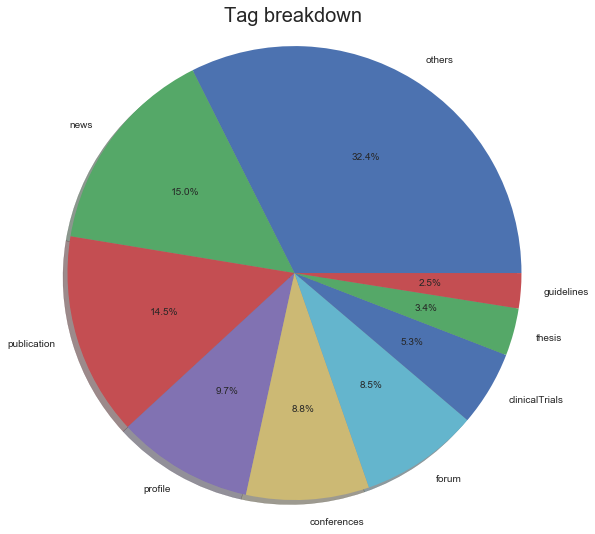

In [316]:
# Breakdown by tag category
train['Tag'].value_counts(normalize = True).plot.pie(autopct='%1.1f%%', shadow=True, startangle=0, figsize=(9,9))
plt.title('Tag breakdown', fontsize=20)
plt.axis('equal')
plt.ylabel('')
plt.show()

In [317]:
train['Tag'].groupby(train['Domain']).value_counts()

Domain                                                           Tag           
1.eyefortravel.com                                               others              2
101bestandbrightest.com                                          others             19
1033ampradio.cbslocal.com                                        others              8
124.205.33.103:81                                                publication        25
14.139.60.56:84                                                  others              1
14four.me                                                        others              1
150.registerguard.com                                            others              1
178.62.86.108                                                    others              1
1millionhealthworkers.org                                        others             14
2012.ispad.org                                                   others              1
2013.ispad.org                                    

### Test Set

In [318]:
test.head()

,Webpage_id,Domain,Url
0,31,isrctn.com,http://www.isrctn.com/ISRCTN57801413
1,32,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-search/trial/2006-006214-16/GB
2,33,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-search/trial/2006-004265-34/LT
3,34,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-search/trial/2010-022183-12/IT
4,35,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-search/trial/2010-021349-36/NL


In [319]:
test.shape

(25787, 3)

In [320]:
test.duplicated(['Url']).sum()

0

In [321]:
test.isnull().sum()

Webpage_id    0
Domain        0
Url           0
dtype: int64

In [322]:
test['Domain'].nunique()

2150

## Data preprocessing - Split Url into Keywords

### Define pre-processing functions

In [323]:
# Function to split url
def SplitURL(url):
    return re.compile(r'[\:/?=\-&%+._,();]+',re.UNICODE).split(url)

# Function to remove digit
def stripdigit(url):    
    return re.sub(r'\d+', '', url)

# Function to remove small word

def smallword(url):
    text = url.split()
    resulttext =[word for word in text if len(word)>2]
    return ' '.join(resulttext)

# Function to remove a list of stopword

stopwords = ['filters','sort','offset','totalresults','page','pagesize','searchtype','basic','search', 'query', 'index',\
            'username','html', 'open', 'bin','aspx', 'www','org','php','com','view','lastedited','numberperpage', 'pagenum', \
             'releasestype', 'sortorder', 'date', 'ascending', 'descending','year','user', 'login','tag','html','default',\
            'rss','upload','eudract','htm','number','fulltext', 'lang','pages','currentpage','xhtml','atmweb', 'appmanager',\
            'atm','atmregistry','dar', 'true', 'tno', 'and','mit','for','asp','europe','australia',\
            'zealand','what','url','your','our','the','from','you','zhtml','all','how','its','fwww',\
            'this','our','english','why','their','after','row','that','who','shtml','https','jsp',\
            'menu','smenu','searchresult','not','into','most','over','link','when','los','online',\
            'wwwext','iii','share','ssl','epage','spage','ceo','flypage','pubmed','with','web', 'navigate', 'navigationid',\
            'portal','study', 'cfm', 'pgid','ahrcdovlddytzwrzyfwzsjbvdmlldfydgljbguvodgmje','cbadffcac']

def remove_stopwords(url):
    querywords = url.split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    return ' '.join(resultwords)

#Object Standardization

standard_dict = {'ctr':'clinical trial', 'clinicaltrialsregister':'clinical trial', 'pactr':'clinical trial',\
                 'clinicaltrials':'clinical trial','trials':'clinical trial','trialreview':'clinical trial','newsmedia':'news media',\
                 'satprnews':'news', 'statnews':'news','positivepsychologynews':'news', 'newsmaker':'news', 'trialsearch':'clinical trial',\
                 'trialregister':'clinical trail','snews':'news', 'mwnewsroom':'news','newsarticle':'news article',\
                 'articleid':'article', 'naturalnews':'news', 'fnews':'news','articles':'article','abs':'abstract',\
                 'acrossref':'crossref', 'snctp':'clinical trial', 'trial':'clinical trial','showthread':'forums','forum':'forums',\
                 'speakerid':'speaker','speakers':'speaker','professionalassociations':'association','newsinfo':'news',\
                 'presspublicationsdoclib':'press publications','aciwebinar':'webinar','fevents':'event','events':'event' }

def standardized_word(url):
    words = url.split()
    standardized_words =[]
    
    for word in words:
        if word.lower() in standard_dict:
            word = standard_dict[word.lower()]
        standardized_words.append(word) 
        new_text = " ".join(standardized_words)
    return new_text
    

## Train Set Pre-Processing

#### Split url into Keywords

In [324]:
train_text = train['Url'].tolist()

train_keywords = []

for url in train_text:
    split_word =  SplitURL(url)
    del split_word[0]
    train_keywords.append(split_word)

In [325]:
# Create training dataframe 
df_train = pd.DataFrame()
df_train['Webpage_id'] = train['Webpage_id']
df_train['keywords'] = train_keywords
df_train['tag'] = train['Tag']

In [326]:
keywords = df_train['keywords'].apply(lambda x: ' '.join(x))
keywords = keywords.str.lower()

#### Remove Digits

In [327]:
train_text2 = keywords.tolist()

train_keywords2 = []

for url in train_text2:
    strip_digit =  stripdigit(url)
    train_keywords2.append(strip_digit)

#### Remove stopword

In [328]:
train_keywords3 = []

for url in train_keywords2:
    remove_stopword =  remove_stopwords(url)
    train_keywords3.append(remove_stopword)

#### Standardized words

In [329]:
train_keywords4 = []

for url in train_keywords3:
    standard_word = standardized_word(url)
    train_keywords4.append(standard_word)

#### Remove smallword

In [330]:
train_keywords5 = []

for url in train_keywords4:
    remove_smallword =  smallword(url)
    train_keywords5.append(remove_smallword)

In [331]:
df_train['keywords'] = train_keywords5

## Test Set Pre-Processing

#### Split url into Keywords

In [332]:
test_text = test['Url'].tolist()

test_keywords = []

for url in test_text:
    split_word =  SplitURL(url)
    del split_word[0]
    test_keywords.append(split_word)

In [333]:
# Create test result dataframe 
df_test = pd.DataFrame()
df_test['Webpage_id'] = test['Webpage_id']
df_test['keywords'] = test_keywords

In [334]:
test_words = df_test['keywords'].apply(lambda x: ' '.join(x))
test_words = test_words.str.lower()

#### Remove Digits

In [335]:
test_text2 = test_words.tolist()

test_keywords2 = []

for url in test_text2:
    strip_digit =  stripdigit(url)
    test_keywords2.append(strip_digit)

#### Remove stopword

In [336]:
test_keywords3 = []

for url in test_keywords2:
    remove_stopword =  remove_stopwords(url)
    test_keywords3.append(remove_stopword)

#### Standardized words

In [337]:
test_keywords4 = []

for url in test_keywords3:
    standard_word = standardized_word(url)
    test_keywords4.append(standard_word)

#### Remove smallword

In [338]:
test_keywords5 = []

for url in test_keywords4:
    remove_smallword =  smallword(url)
    test_keywords5.append(remove_smallword)

In [339]:
df_test['keywords'] = test_keywords5

#### Further Checking

In [340]:
freq = pd.Series(' '.join(df_train['keywords']).split()).value_counts()[:10]
freq

article          5687
news             4429
edu              4412
clinical         4118
biomedcentral    3672
content          2951
trial            2857
about            2158
bayer            1909
gov              1897
dtype: int64

In [341]:
lessfreq_train = pd.Series(' '.join(df_train['keywords']).split()).value_counts()[-300:]
lessfreq_train

sellmyhome               1
endobronquial            1
declaring                1
fmb                      1
sung                     1
prehabilitation          1
bri                      1
rebay                    1
aux                      1
glasers                  1
csaci                    1
acl                      1
zpwq                     1
denying                  1
kalhorn                  1
fallout                  1
zhangfmitedu             1
stomaxi                  1
bhm                      1
whova                    1
universita               1
cheers                   1
adviseinformation        1
juju                     1
heel                     1
coffey                   1
oosterbaan               1
hridroga                 1
naomi                    1
cully                    1
fabe                     1
grodman                  1
muris                    1
bphoto                   1
tbiomed                  1
melani                   1
avodart                  1
b

In [342]:
lessfreq_trainl = list(lessfreq_train.index)
df_train['keywords'] = df_train['keywords'].apply(lambda x: " ".join(x for x in x.split() if x not in lessfreq_trainl))
df_train['keywords'].head()

0             fiercepharma marketing tecfidera gilenya aubagio way battle about get more interesting
1                               fiercepharma pharma novo equipped weather storm diabetes market says
2                      fiercepharma pharma another exec departs troubled endo time another drugmaker
3                                fiercepharma pharma teva buy biosim specialist celltrion wouldn say
4    fiercepharma marketing actress marissa tomei partners allergan restasis drive dry eye awareness
Name: keywords, dtype: object

In [343]:
lessfreq_test = pd.Series(' '.join(df_test['keywords']).split()).value_counts()[-300:]
lessfreq_test

roundup                1
compromise             1
sac                    1
aciworldwide           1
maintain               1
mtrr                   1
testim                 1
itunes                 1
cifarelli              1
kdyf                   1
cholinergic            1
businesscreditbuddy    1
spec                   1
rohe                   1
qvwt                   1
alm                    1
acids                  1
referralcoin           1
beleive                1
diggety                1
aiche                  1
bringay                1
otitis                 1
jola                   1
holdings               1
borne                  1
babsonathletics        1
marygrace              1
crystalrugged          1
eiffel                 1
brooks                 1
bmhmj                  1
unhealthy              1
sharedresource         1
revelations            1
lini                   1
weeklet                1
decent                 1
asoka                  1
extremist              1


In [344]:
lessfreq_testl = list(lessfreq_test.index)
df_test['keywords'] = df_test['keywords'].apply(lambda x: " ".join(x for x in x.split() if x not in lessfreq_testl))
df_test['keywords'].head()

0                                   isrctn isrctn
1    clinical trial clinical trial clinical trial
2    clinical trial clinical trial clinical trial
3    clinical trial clinical trial clinical trial
4    clinical trial clinical trial clinical trial
Name: keywords, dtype: object

In [345]:
df_train.to_csv('train_clean.csv', index=False)

In [346]:
df_test.to_csv('test_clean.csv', index=False)

## Model Implementation

In [347]:
df_train2 = pd.read_csv('train_clean.csv')
df_test2 = pd.read_csv('test_clean.csv')

### Features

In [348]:
Xtrain = df_train2['keywords']
Xtest = df_test2['keywords']

In [349]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
Ytrain = encoder.fit_transform(df_train2['tag'].astype(str))

#### Count vectorizer features

In [350]:
df_combine = pd.concat([df_train2['keywords'], df_test2['keywords']])

In [351]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df_combine.values.astype('U'))

# transform the training data using count vectorizer object
Xtrain_count =  count_vect.transform(Xtrain.values.astype('U'))
Xtest_count =  count_vect.transform(Xtest.values.astype('U'))

#### Characters level tf-idf

In [352]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df_combine.values.astype('U'))
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(Xtrain.values.astype('U')) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(Xtest.values.astype('U')) 

C:\Users\linat\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


### Model 

In [353]:
def tag_classification(classifier, feature_vector_train, tag, feature_vector_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, tag)
    
    # predict the labels on validation dataset
    df_test2['Prediction'] = classifier.predict(feature_vector_test)

In [354]:
tag_classification(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, Ytrain, xtest_tfidf_ngram_chars)

In [355]:
 df_test2['Tag'] = encoder.inverse_transform(df_test2['Prediction'])

C:\Users\linat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [360]:
# Drop columns to keep only id, renewal and incentives  
df_test2.drop(['keywords','Prediction'], inplace=True, axis=1)

In [361]:
df_test2.head()

,Webpage_id,Tag
0,31,clinicalTrials
1,32,clinicalTrials
2,33,clinicalTrials
3,34,clinicalTrials
4,35,clinicalTrials


In [362]:
df_test2.to_csv('innoplexus_submission7.csv', index=False)

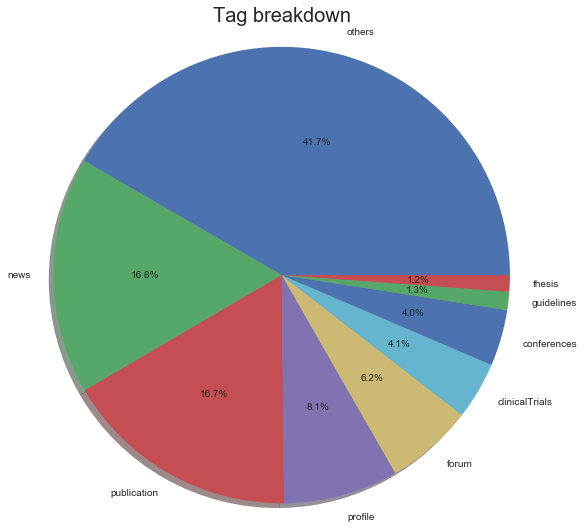

In [363]:
# Breakdown by tag category
df_test2['Tag'].value_counts(normalize = True).plot.pie(autopct='%1.1f%%', shadow=True, startangle=0, figsize=(9,9))
plt.title('Tag breakdown', fontsize=20)
plt.axis('equal')
plt.ylabel('')
plt.show()